## Data

In [2]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import random


In [3]:
def load_months(X, stock):
    data = yf.download(stock, start='2010-01-01', end='2023-12-31', interval='1d')
    m = 1000
    for yr in data.index.year.unique():
        for mth in data.index.month.unique():
            if mth == 12:
                if yr == 2023:
                    continue
                d = data[(data.index.year == yr) & (data.index.month == mth) | (data.index.year == yr +1 ) & (data.index.month == 1)].Close.values
            else : 
                d = data[(data.index.year == yr) & (data.index.month.isin([mth, mth%12 + 1])) ].Close.values
            if len(d) < 38:
                continue
            X.append(d[:38])

In [4]:
normalized = True
X = []
if normalized == False:    
    tickers = stocks = [
    "AAPL", "GOOGL", "MSFT", "AMZN", "TSLA", "V", "JNJ", "WMT", "PG", "UNH", "MA", "NVDA", "HD", "BAC", "DIS", "VZ", "PYPL", "CMCSA",
    "ADBE", "NFLX", "INTC", "T", "PFE", "KO", "MRK", "PEP", "NKE", "ABT", "CRM", "XOM", "ACN", "ORCL", "CSCO", "ABBV", "TMO", "AVGO", "QCOM", "COST",
    "LLY", "MCD", "MDT", "DHR", "HON", "WFC", "UPS", "LIN", "BMY", "BA", "UNP", "TXN", "NEE", "LOW", "SAP", "IBM", "AMGN", "SBUX", "GE", "RTX",
    "CAT", "CVX", "GS", "MMM", "C", "LMT", "FIS", "MS", "BLK", "TGT", "DE", "SCHW", "ISRG", "NOW", "MO", "MDLZ", "MU", "PNC", "NSC", "INTU",
    "DXCM", "SYK", "GILD", "TJX", "ADP", "CI", "F", "GM", "AMAT", "CSX", "BKNG", "CL", "SPGI", "BDX", "ZTS", "REGN", "ATVI", "VRTX", "USB"
]
    for ticker in tickers:
        load_months(X, ticker)

    X = np.array(X)
    random.shuffle(X)

else:
    data = pd.read_csv('sliced_data.csv')
    Xordered = data.values
    np.array(Xordered)
    indices = np.arange(Xordered.shape[0])
    np.random.shuffle(indices)

    X = Xordered[indices]


In [5]:
train_X= torch.from_numpy(X[:int(len(X)*0.7)]).float()
test_X= torch.from_numpy(X[int(len(X)*0.7):]).float()

train_loader = DataLoader(train_X, batch_size=8, shuffle=True)
test_loader = DataLoader(test_X, batch_size=1, shuffle=True)


## VAE Model

In [6]:
class VAE(nn.Module):
    
    def __init__(self):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(60, 50),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(50, 40),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(40, 30),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(30, 20),
            nn.ReLU(),
        )

        # map to latent z
        self.fc11 = nn.Linear(20, 10)
        self.fc12 = nn.Linear(20, 10)

        # decoder
        self.fc2 = nn.Linear(10, 20)
        self.decoder = nn.Sequential(
            nn.Linear(20, 30),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(30, 40),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(40, 50),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(50, 60),
            nn.ReLU(),
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc11(h), self.fc12(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        img = self.decoder(self.fc2(z))
        return img

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

  
def loss_function(recon_x, x, mu, logvar,k_recons=1,k_kl=0.1):
    
    BCE = nn.MSELoss()(recon_x, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return k_recons*BCE + k_kl*KLD

## Training

In [7]:
k_recons = 1
k_kl = 0.05

In [8]:
# device to train our network
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)

# optimizer chosen
optimizer = optim.Adam(model.parameters(), lr=0.002)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)


def train(start_epochs=1, n_epochs=2, test_loss_min_input=np.Inf, train_loader = train_loader, test_loader = test_loader, model=model, optimizer=optimizer):
    test_loss_list = []
    train_loss_list = []
    # initialize tracker for minimum validation loss
    test_loss_min = test_loss_min_input 
    
    for epoch in range(start_epochs, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        test_loss = 0.0
        
        ###################
        # train the model #
        ###################

        model.train()
        for batch_idx, data in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar,k_recons,k_kl)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        scheduler.step()

        ######################    
        # validate the model #
        ######################
        
        model.eval()
        for _ , data in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar,k_recons,k_kl)
            test_loss += loss.item()
            

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tTest Loss: {:.6f}'.format(
            epoch, 
            train_loss/len(train_loader.sampler),
            test_loss/len(test_loader.sampler)
            ))
        train_loss_list.append(train_loss/len(train_loader.sampler))
        test_loss_list.append(test_loss/len(test_loader.sampler))

        # save the model if test loss has decreased
        if test_loss <= test_loss_min:
            print('Test loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(test_loss_min,test_loss))
            # save checkpoint as best model
            test_loss_min = test_loss
            torch.save(model.state_dict(),"VAEModel.pth")
        
    plt.plot(train_loss_list[3:], label='train')
    plt.plot(test_loss_list[3:], label='test')
    plt.legend()
    plt.show()

Epoch: 1 	Training Loss: 0.010042 	Test Loss: 0.062824
Test loss decreased (inf --> 71.807846).  Saving model ...
Epoch: 2 	Training Loss: 0.008605 	Test Loss: 0.062846
Epoch: 3 	Training Loss: 0.008499 	Test Loss: 0.066431
Epoch: 4 	Training Loss: 0.008492 	Test Loss: 0.063085
Epoch: 5 	Training Loss: 0.008399 	Test Loss: 0.062666
Test loss decreased (71.807846 --> 71.626828).  Saving model ...
Epoch: 6 	Training Loss: 0.008405 	Test Loss: 0.062685
Epoch: 7 	Training Loss: 0.008364 	Test Loss: 0.062745
Epoch: 8 	Training Loss: 0.008369 	Test Loss: 0.062633
Test loss decreased (71.626828 --> 71.589463).  Saving model ...
Epoch: 9 	Training Loss: 0.008398 	Test Loss: 0.062648
Epoch: 10 	Training Loss: 0.008379 	Test Loss: 0.062517
Test loss decreased (71.589463 --> 71.456450).  Saving model ...
Epoch: 11 	Training Loss: 0.008347 	Test Loss: 0.062723
Epoch: 12 	Training Loss: 0.008315 	Test Loss: 0.062555
Epoch: 13 	Training Loss: 0.008333 	Test Loss: 0.062562
Epoch: 14 	Training Loss: 0

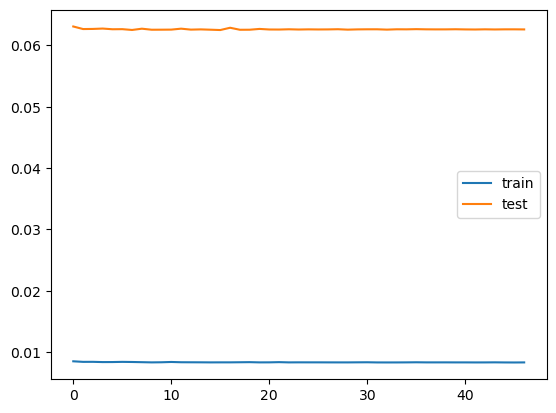

In [9]:
train(n_epochs=50)

## Generate

In [10]:
vae_model = VAE()
vae_model.load_state_dict(torch.load('VAEModel.pth'))
vae_model.eval()

# Définir le nombre de données à générer
nombre_de_donnees = 50

# Échantillonner à partir de la distribution latente
with torch.no_grad():
    z = torch.randn(nombre_de_donnees, 10)
    display(z)

# Décoder les échantillons
donnees_generees = vae_model.decode(z)

tensor([[-3.8641e-01,  1.4318e+00, -9.6294e-01, -1.4596e+00,  1.3413e+00,
          1.1233e+00,  1.1730e+00,  2.9582e-01,  1.1107e+00, -6.3533e-01],
        [ 2.8676e-01, -1.3993e-01, -1.4545e+00,  7.3347e-01, -1.3208e+00,
          3.7888e-01, -7.5049e-02,  7.8921e-01,  9.3091e-01, -1.6298e-01],
        [ 2.4218e-01,  4.4917e-01,  1.7879e+00,  8.1087e-01,  9.4964e-01,
         -5.7831e-01,  1.4345e+00, -2.1547e+00, -1.1530e-01,  1.3495e+00],
        [-5.5863e-01,  7.2364e-01,  2.9891e-01, -1.3347e+00, -9.0374e-01,
         -1.2066e+00, -3.4405e-01, -2.2195e-01,  3.2618e-01, -1.2096e+00],
        [ 8.1435e-01,  1.3568e+00, -1.2822e+00, -7.3954e-01,  2.1435e+00,
          8.2627e-01, -5.0842e-01, -9.8286e-01, -8.9656e-01, -2.5182e-01],
        [ 1.4475e+00, -8.5277e-01,  8.6180e-01,  1.7832e+00, -4.4280e-01,
          1.2059e+00,  2.4711e-01,  2.8202e-01,  1.0381e+00, -4.2514e-01],
        [-9.6770e-01,  2.2593e-01,  8.2843e-01, -1.1535e+00,  8.0625e-01,
         -9.4808e-01, -7.9012e-0

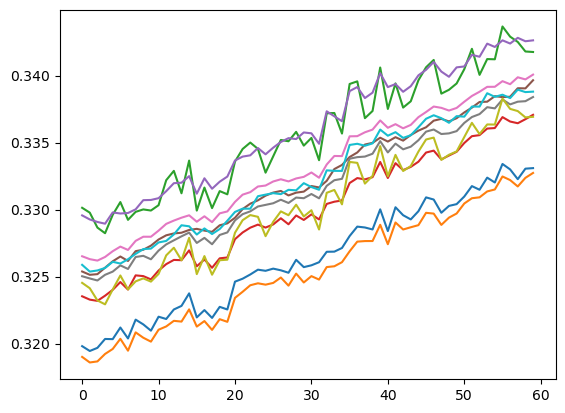

In [15]:
for serie in donnees_generees[:10]:
    plt.plot(serie.detach().numpy())

plt.show()

## PCA on generated data

In [12]:
from sklearn.decomposition import PCA
sliced = pd.read_csv("sliced_data.csv")
pca = PCA(n_components=2)
pca.fit(sliced)
gen_pca = pca.transform(donnees_generees.detach().numpy())

/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


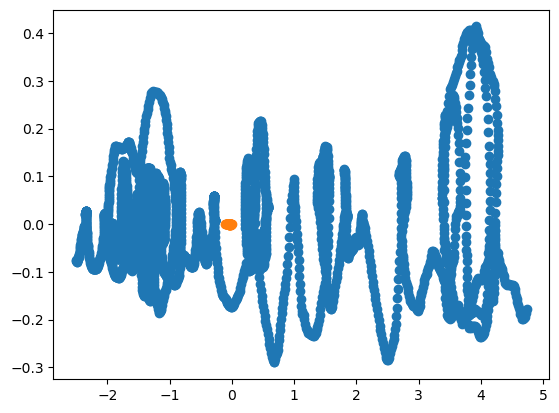

In [13]:
right_pca = pd.read_csv("sliced_data_pca.csv")
plt.scatter(right_pca.iloc[:,0].values, right_pca.iloc[:,1].values)
plt.scatter(gen_pca[:,0], gen_pca[:,1])
